In [1]:
#################

## imports 

#################

import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
from scipy.misc import derivative
from matplotlib import animation
import matplotlib.cm as cm
#from matplotlib import colors

%matplotlib notebook

In [75]:
################

def redefine_arctan(slope):
    theta = np.arctan(slope)
    if theta>=0:
        return(theta)
    else:
        return(theta + np.pi)
    

# function to return lakebed y for given x
def lakebed(x):
    global amplitude_sin, amplitude_cos, frequency_sin, frequency_cos
    return(depth_of_water_column - 
              amplitude_sin*np.sin(2*np.pi*x*frequency_sin/width) - 
              amplitude_cos*np.cos(x*frequency_cos))

################
#return slope of line of path of individual
def path_slope(x1,y1,x2,y2):
    if x1 == x2:
        return(np.inf)
    else:
        return((y2-y1)/(x2-x1))

################
#return intercept of line of path of individual
def path_intercept(x1,y1,x2,y2):
    c = y2 - x2*path_slope(x1,y1,x2,y2)
    return(c)
    
################
#for given x, return y of path of individual
def intersection_function(x):
    h = lakebed(x) - path_function(x)
    return(h)


################
#calculate point of intersection between lakebed and path
def intersection_point_lakebed(x1,y1,x2,y2):
    if x1 == x2: #slope is inf
        x_int = x1
        y_int = lakebed(x_int)
    else:
        x_int = scipy.optimize.fsolve(intersection_function, x2)
        y_int = path_function(x_int)
    return(x_int,y_int)


################
#calculate point of intersection between water surface and path
def intersection_point_water(x1,y1,x2,y2):
    if x1 == x2:
        x_int = x1
    else:
        m = path_slope(x1,y1,x2,y2)
        x_int = x2 - y2/m
    y_int = 0
    return(x_int,y_int)

################
#for given x, return y of path of individual
def path_function(x):
    global x1,y1,x2,y2
    m = path_slope(x1,y1,x2,y2)
    c = path_intercept(x1,y1,x2,y2)
    return(m*x + c)


#################
# function to check if path intersects with water
def intersect_water(x,y):
    if y < 0:
        return(True)
    else:
        return(False)

    
#################
# function to check if path intersects with lake bed
def intersect_lakebed(x,y):
    if y > lakebed(x):
        return(True)
    else:
        return(False)
    
#################
# function to return final x and y coods of individual reflected off surface of water
def reflect_water(x1,y1,x2,y2):
    
    x_ref = x2
    y_ref = -y2
    return(x_ref,y_ref)

#################
# function to return final x and y coods of individual reflected off surface of lake bed
def reflect_lakebed(x1,y1,x2,y2):
    if (x1 == x2) & (y1 > y2):
        angle2 = -90*np.pi/180
        #print("vertical down")
    elif (x1 == x2) & (y1 <= y2):
        angle2 = 90*np.pi/180
        #print("vertical up")
    else:
        #print("neither")
        slope = path_slope(x1,y1,x2,y2)
        angle2 = redefine_arctan(slope)
#     print(slope)
#     print(angle2)
    x_int, y_int = intersection_point_lakebed(x1,y1,x2,y2)
#     print(x_int,y_int)
    distance = np.sqrt((x_int - x1)**2 + (y_int - y1)**2)
#     print(distance)
    angle1 = redefine_arctan(derivative(lakebed,x_int))
#     print(angle1)
    x_ref = (x_int + (step_length-distance)*np.cos(2*angle1 - angle2))%width
    y_ref = y_int + (step_length-distance)*np.sin(2*angle1 - angle2)
    return(x_ref,y_ref)

In [61]:
#################

## parameters

#################

num_animals = 20
max_time_steps = 2000
amplitude_sin = 50
amplitude_cos = 0
frequency_sin = 0.5
frequency_cos = 0

depth_of_water_column = 100 #>> amplitude
width = 100
x_over_time = np.zeros((num_animals,max_time_steps))
y_over_time = np.zeros((num_animals,max_time_steps))
step_length = 10
strength_of_attraction = 1
strength_of_lake_bed_reflection = 0.5 #0 (move along lake bed) to 1
sigma = 90 #degrees - inverse of measure of correlation

lake_bed_x = np.arange(0,width,width/100)
lake_bed_y = (depth_of_water_column - 
              amplitude_sin*np.sin(2*np.pi*lake_bed_x*frequency_sin/width) - 
              amplitude_cos*np.cos(lake_bed_x*frequency_cos)) #+ 2*np.max((amplitude_cos,amplitude_sin))

In [59]:
#################

## initialise

#################

#give random locations (x and y) to all animals

x = np.random.choice(width,(num_animals))
y = np.random.choice(int(np.floor(depth_of_water_column-max(amplitude_sin,amplitude_cos))),(num_animals))
theta_previous = np.random.uniform(0,360,size = (num_animals))
preferred_depth = 5

In [89]:
#################

## update function

#################

#function to apply correlated random walk to animals with attraction to preferred depth and apply rules
def move(time_i):
    global x1,y1,x2,y2, num_animals, sigma, strength_of_attraction, step_length, x, y, theta_previous, preferred_depth
    
    preferred_depth = (depth_of_water_column/3)*np.sin(2*np.pi*time_i/100) + (depth_of_water_column/2)
    debugging = False
    #choose direction in which to move (correlated random walk to animals with attraction to preferred depth)
    theta_new_correlation = np.random.normal(theta_previous,sigma, size = (num_animals))
    
    #print(theta_new_correlation)
    
    dx_correlation = step_length*np.cos(theta_new_correlation*np.pi/180)
    dy_correlation = step_length*np.sin(theta_new_correlation*np.pi/180)
    #print(dx_correlation, dy_correlation)
    
    #attraction towards preferred depth
    dx_dvm = 0
    dy_dvm = strength_of_attraction*(preferred_depth - y)
    #print(dy_dvm)
    
    #adding the two vectors
    dx = dx_correlation + dx_dvm 
    dy = dy_correlation + dy_dvm
    #print(dx,dy)
    
    #normalizing the vector
    dx_norm = dx*np.sqrt(step_length)/(np.sqrt(dx**2 + dy**2))
    dy_norm = dy*np.sqrt(step_length)/(np.sqrt(dx**2 + dy**2))
    #print(dx_norm, dy_norm)
    
    #print(dx_norm, dy_norm)
    
    theta_final = np.arcsin(dy_norm/step_length)*180/np.pi
    #print(theta_final)
    
    x_new = (x + dx_norm)%width
    y_new = y + dy_norm
    #print(x_new,y_new)
    for i in range(num_animals):
        x1 = x[i]
        y1 = y[i]
        x2 = x_new[i]
        y2 = y_new[i]
        if debugging == True:
            print(i, x1, y1, x2, y2)
        while intersect_water(x2, y2) | intersect_lakebed(x2,y2):
            if intersect_water(x2, y2): #if path intersects with water surface
                
                x2, y2 = reflect_water(x1,y1,x2,y2)#reflect
                if debugging == True:
                    print("Water surface intersection")
                    print(x2,y2)
                

            if intersect_lakebed(x2, y2): #if path intersects with lake bed
                x2, y2 = reflect_lakebed(x1,y1,x2,y2)#reflect
                if debugging == True:
                    print("Lakebed intersection")
                    print(x2,y2)
                
        x[i] = x2 #update path
        y[i] = y2
    theta_previous = theta_final
    return(x,y,theta_previous, preferred_depth)
#     if ANIMATE:
#         data = np.hstack((x[:,np.newaxis], y[:, np.newaxis]))
#         scatter.set_offsets(data)
#         plt.show()
    
#     return(scatter)
    #return(x_new,y_new,theta_previous)
    

In [123]:
############   run simulation ##################
x = np.random.choice(width,(num_animals))
y = np.random.choice(int(np.floor(depth_of_water_column-max(amplitude_sin,amplitude_cos))),(num_animals))
theta_previous = np.random.uniform(0,360,size = (num_animals))
preferred_depth = 5
max_time_steps = 1000
max_time_steps_record = max_time_steps/10
amplitude_sin = 5
amplitude_cos = 0
lake_bed_x = np.arange(0,width,width/100)
lake_bed_y = (depth_of_water_column - 
              amplitude_sin*np.sin(2*np.pi*lake_bed_x*frequency_sin/width) - 
              amplitude_cos*np.cos(lake_bed_x*frequency_cos)) #+ 2*np.max((amplitude_cos,amplitude_sin))
# x_over_time = np.zeros((num_animals,max_time_steps_record))
# y_over_time = np.zeros((num_animals,max_time_steps_record))
dist_depth65_even = np.array(())
for time in range(max_time_steps):
    x, y, theta_previous,preferred_depth = move(time)
#     if time == 0:
        
# #     if time%10 == 0:
    if (preferred_depth >60) & (preferred_depth < 71):
        dist_depth65_even = np.append(x,dist_depth65_even)
#         fig, ax = plt.subplots()
#         plt.plot(lake_bed_x,lake_bed_y, color = "green")
#         scatter = ax.scatter(x, y)
#         plt.hlines(0,0,width)
#         plt.hlines(preferred_depth,0,width, color = "red")
#         plt.vlines(0,0,depth_of_water_column)
#         plt.vlines(width,0,depth_of_water_column)
#         ax = plt.gca()
#         ax.invert_yaxis()
#         plt.show()
#     if (preferred_depth >60) & (preferred_depth < 71):
#         print("Condition satisfied")
#         fig, ax = plt.subplots()
#         plt.hist(x)
#         plt.show()  
        
# save x in x_over_time and then plot hist

<IPython.core.display.Javascript object>


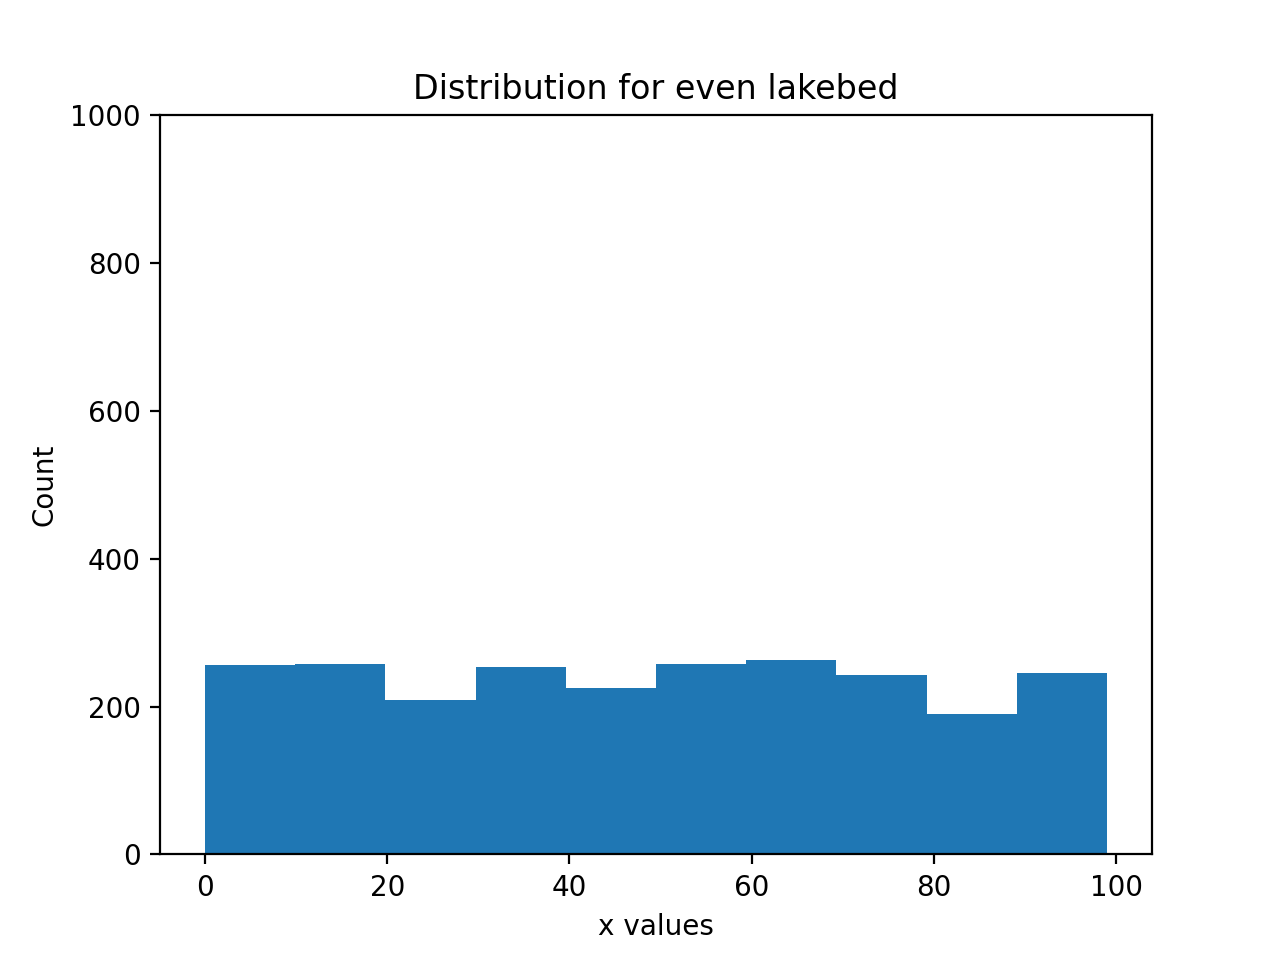

(0.0, 1000.0)

In [124]:
fig,ax = plt.subplots()
plt.hist(dist_depth65_even)
ax.set_xlabel("x values")
ax.set_ylabel("Count")
ax.set_title("Distribution for even lakebed")
ax.set_ylim(0,1000)